# TREINAMENTO REDE EFFICIENTNET v4.2EF.30e.CG4


> Com os pesos congelados

> Com separação de indivíduo

## Constantes

In [1]:
# REDE UTILIZADA:
MODEL_TYPE = 'efficient-net'

# DATASET UTILIZADO:
DATASET_TYPE = 'clustering-groups'
ehCompleto = True

# PARÂMETROS UTILIZADOS:

EPOCHS = 30

BATCH = 512

SIZE = 100

TARGET = (100, 100)

SEED = 10

N_SPLITS = 5

VERSION = 'v4.2EF.30e.CG4'

In [2]:
# INDIVÍDUOS EM CADA SPLIT

NORMAL_SPLITS = [[2, 10, 15], 
                [6, 11, 14], 
                [1, 5, 7], 
                [8, 9, 16, 13], 
                [12, 3, 4],]

SICK_SPLITS = [[38, 33, 28, 23, 45, 43], 
                [22, 24, 17, 37, 35, 32], 
                [21, 25, 34, 27, 19, 31], 
                [18, 41, 42, 30, 29, 46], 
                [20, 39, 26, 40, 44, 36, 47],]

## Configurando Ambiente

In [3]:
!nvidia-smi

Tue Oct 29 12:00:26 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
!pip install efficientnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.6 MB/s eta 0:00:00


## Bibliotecas e Diretórios

In [5]:
# BIBLIOTECAS GERAIS

import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import sys
import random

# BIBLIOTECAS DEEP LEARNING

import datetime
import tensorflow as tf
from tensorflow.keras import layers

from sklearn.metrics import auc, classification_report, confusion_matrix, roc_curve
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.preprocessing import image

from efficientnet.tfkeras import EfficientNetB7

2024-10-29 12:00:45.863767: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-29 12:00:45.863899: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-29 12:00:46.188277: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
# DIRETÓRIOS

DATASET_PATH = f'/kaggle/input/myocardits-dataset-clustering-groups/GRUPO_4/'
RESULTS_PATH = f'/kaggle/working/{DATASET_TYPE}'

NORMAL_INDIVIDUOS = [f'Individuo_{i:02}' for i in range(1, 17)]
SICK_INDIVIDUOS = [f'Individuo_{i:02}' for i in range(17, 48)]

# Pasta com resultados
if not os.path.exists(f'{DATASET_TYPE}'):
    os.mkdir(f'{DATASET_TYPE}')
    
# Configurando seeds
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

## Carregamento e Processamento de Imagens

In [7]:
num_imagens = 0

def processamento_imagens(img):
    global num_imagens
    
    # Redimensiona e reescala a imagem
    resize_and_rescale = tf.keras.Sequential([
        layers.Resizing(100, 100),
        layers.Rescaling(1./255)
    ])
    
    # Aplica o redimensionamento e o reescalamento
    img = resize_and_rescale(img)
    
    # Converte a imagem para float32
    img = tf.cast(img, tf.float32)  
    img = np.array(img)
    
    # Atualiza o contador de imagens processadas
    num_imagens += 1
    sys.stdout.write("\rNumero de imagens carregadas: %i" % num_imagens)
    sys.stdout.flush()
    
    return img

import cv2

def carregar_imagens(diretorio):
    imagens = []
    
    for pasta_atual, _, arquivos in os.walk(diretorio):
        for arquivo in arquivos:
            if arquivo.endswith('.jpg') or arquivo.endswith('.png'):
                caminho = os.path.join(pasta_atual, arquivo)
                
                # Carrega a imagem em RGB usando OpenCV
                img = cv2.imread(caminho, cv2.IMREAD_COLOR)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
                # Processa a imagem
                imagem_processada = processamento_imagens(img)
                imagens.append(imagem_processada)
    
    return imagens


In [8]:
# PERCORRENDO O DIRETÓRIO

normal_paths = []
for individuo in NORMAL_INDIVIDUOS:
    directory = f'{DATASET_PATH}/Normal/{individuo}/'
    normal_paths.append(directory)

sick_paths = []
for individuo in SICK_INDIVIDUOS:
    directory = f'{DATASET_PATH}/Sick/{individuo}/'
    sick_paths.append(directory)

# SEPARAÇÃO DOS DATASETS ENTRE OS SPLITS

normal_splits = [[],[],[],[],[]]
sick_splits = [[],[],[],[],[]]

for split in range(N_SPLITS):
    normal_splits[split].extend(normal_paths[i-1] for i in NORMAL_SPLITS[split])
    sick_splits[split].extend(sick_paths[i-17] for i in SICK_SPLITS[split])

# CARREGANDO E PROCESSANDO AS IMAGENS

print('\nIniciando carregamento e processamento das imagens..............!')

print('\nPacientes normais:')
normal_datasets = []
for split in normal_splits:
    imagens = []
    for individuo in split:
        imagens.extend(carregar_imagens(individuo))
    normal_datasets.append(imagens)

num_imagens = 0

print('\nPacientes doentes:')
sick_datasets = []
for split in sick_splits:
    imagens = []
    for individuo in split:
        imagens.extend(carregar_imagens(individuo))
    sick_datasets.append(imagens)

num_imagens = 0

# DATASETS SEPRADAOS EM 5 SPLITS

x_data = [[],[],[],[],[]]
y_data = [[],[],[],[],[]]

print('\n\nNumero de imagens por split:')
for i in range(N_SPLITS):
    x_data[i].extend(path for path in normal_datasets[i])
    y_data[i].extend([1, 0] for path in normal_datasets[i])
    x_data[i].extend(path for path in sick_datasets[i])
    y_data[i].extend([0, 1] for path in sick_datasets[i])
    print(f'Split {i+1}: {len(x_data[i])} imagens ({len(normal_datasets[i])} saudáveis e {len(sick_datasets[i])} doentes).')


Iniciando carregamento e processamento das imagens..............!

Pacientes normais:
Numero de imagens carregadas: 1169
Pacientes doentes:
Numero de imagens carregadas: 1895

Numero de imagens por split:
Split 1: 612 imagens (238 saudáveis e 374 doentes).
Split 2: 591 imagens (215 saudáveis e 376 doentes).
Split 3: 599 imagens (224 saudáveis e 375 doentes).
Split 4: 633 imagens (259 saudáveis e 374 doentes).
Split 5: 629 imagens (233 saudáveis e 396 doentes).


# Treinamento

## Configurando a Rede

In [9]:
# Arquitetura CNN
def cnn_model(input_shape, num_classes):
    base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    
    inputs = layers.Input(shape=input_shape)
    
    x = base_model(inputs)
    x = layers.Flatten()(x)
    x = layers.Dense(100, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.summary()
    
    return model

## Separação de Dados e Treinamento

In [10]:
# SEPARAÇÃO DE DADOS E TREINAMENTO

results = {
    "train_accuracies": [],
    "valid_accuracies": [],
    "test_accuracies": [],

    "train_matrixs": [],
    "valid_matrixs": [],
    "test_matrixs": [],
    
    "test_loss": [],
    "test_accuracy": [],
    
    "reports": [],
    "AUC": [],
    "times": [], 
    "historys": []
}

# TREINAMENTO POR FOLDS

for fold in range(N_SPLITS):

    print(f'\n\nFOLD {fold+1}:')

    # SEPARAÇÃO DO TREINO, TESTE E VALIDAÇÃO
    
    x_test = np.array(x_data[fold])
    y_test = np.array(y_data[fold])
    
    folds = [0, 1, 2, 3, 4]
    folds.remove(fold)

    x_valid = np.array(x_data[folds[0]])
    y_valid = np.array(y_data[folds[0]])
    folds.remove(folds[0])

    x_train, y_train = [], []
    for i in folds:
        x_train.extend(x_data[i])
        y_train.extend(y_data[i])
    x_train = np.array(x_train)
    y_train = np.array(y_train)

    print(f'Numero de imagens no treinamento: {len(x_train)} imagens.')
    print(f'Numero de imagens na validação: {len(x_valid)} imagens.')
    print(f'Numero de imagens no teste: {len(x_test)} imagens.')
    

    # ARQUITETURA E COMPILAÇÃO
    model = cnn_model((SIZE, SIZE, 3), 2)
    OPTIMIZER = AdamW(weight_decay=0.004)
    
    # Compilação do modelo
    model.compile(loss='categorical_crossentropy',
                  optimizer=OPTIMIZER,
                  metrics=['categorical_accuracy'])

    
    # TREINAMENTO
    print('\nIniciando o treinamento.........................................!\n')

    calback = CSVLogger(RESULTS_PATH + f'/logger_fold{fold+1}.log')

    start = datetime.datetime.now()
    
    history = model.fit(x_train, y_train,
                        epochs=EPOCHS,
                        validation_data=(x_valid, y_valid),
                        callbacks=[calback])
    
    results["historys"].append(history)

    end = datetime.datetime.now()
    results["times"].append(end - start)

    # Salvando o modelo
    model.save(RESULTS_PATH + f'/{DATASET_TYPE}-CNN-{fold+1}.keras')

    # TESTE
    print("\nTestando imagens................................................!\n")
    
    loss, accuracy = model.evaluate(x_test, y_test)
    results["test_loss"].append(loss)
    results["test_accuracy"].append(accuracy)

    # ARMAZENAMENTO DOS INFORMACOES
    print("\nCalculando métricas.............................................!\n")

    # METRICAS DO TREINO
    train_predicts = model.predict(x_train).argmax(axis=1)
    train_actuals = y_train.argmax(axis=1)
    
    # Matriz de confusão
    train_matrix = confusion_matrix(train_actuals, train_predicts)
    train_accuracy = np.trace(train_matrix)/np.sum(train_matrix)
    
    results["train_accuracies"].append(train_accuracy)
    results["train_matrixs"].append(train_matrix)

    # METRICAS DO VALIDAÇÃO
    valid_predicts = model.predict(x_valid).argmax(axis=1)
    valid_actuals = y_valid.argmax(axis=1)
    
    # Matriz de confusão
    valid_matrix = confusion_matrix(valid_actuals, valid_predicts)
    valid_accuracy = np.trace(valid_matrix)/np.sum(valid_matrix)
    
    results["valid_accuracies"].append(valid_accuracy)
    results["valid_matrixs"].append(valid_matrix)

    # METRICAS DO TESTE
    test_predicts = model.predict(x_test).argmax(axis=1)
    test_actuals = y_test.argmax(axis=1)
    
    # Matriz de confusão
    test_matrix = confusion_matrix(test_actuals, test_predicts)
    test_accuracy = np.trace(test_matrix)/np.sum(test_matrix)
    
    results["test_accuracies"].append(test_accuracy)
    results["test_matrixs"].append(test_matrix)

    # Calculando ROC e RELATORIO DE CLASSIFICAÇÃO
    fpr, tpr, _ = roc_curve(test_actuals, test_predicts, pos_label=1)
    results["AUC"].append(auc(fpr, tpr))
    
    results["reports"].append(classification_report(test_actuals, test_predicts, zero_division=1))



FOLD 1:
Numero de imagens no treinamento: 1861 imagens.
Numero de imagens na validação: 591 imagens.
Numero de imagens no teste: 612 imagens.
258434480/258434480 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_3065"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3065 (InputLayer)   │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnet-b7 (Functional)    │ (None, 4, 4, 2560)     │    64,097,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 40960)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │     4,096,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,193,982 (260.14 MB)

 Trainable params: 4,096,302 (15.63 MB)

 Non-trainable params: 64,097,680 (244.51 MB)


Iniciando o treinamento.........................................!

Epoch 1/30
 1/59 ━━━━━━━━━━━━━━━━━━━━ 2:04:15 129s/step - categorical_accuracy: 0.6250 - loss: 0.8032

I0000 00:00:1730203461.937730      78 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1730203462.100426      78 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.5610 - loss: 3.7308  

W0000 00:00:1730203577.525377      78 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


59/59 ━━━━━━━━━━━━━━━━━━━━ 257s 2s/step - categorical_accuracy: 0.5613 - loss: 3.7050 - val_categorical_accuracy: 0.6362 - val_loss: 0.6466
Epoch 2/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - categorical_accuracy: 0.6042 - loss: 0.6696 - val_categorical_accuracy: 0.6362 - val_loss: 0.6550
Epoch 3/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - categorical_accuracy: 0.6052 - loss: 0.6560 - val_categorical_accuracy: 0.6362 - val_loss: 0.6662
Epoch 4/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - categorical_accuracy: 0.6026 - loss: 0.7389 - val_categorical_accuracy: 0.6362 - val_loss: 0.6456
Epoch 5/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - categorical_accuracy: 0.6037 - loss: 0.6385 - val_categorical_accuracy: 0.6362 - val_loss: 0.6604
Epoch 6/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - categorical_accuracy: 0.6061 - loss: 0.6241 - val_categorical_accuracy: 0.6362 - val_loss: 0.6712
Epoch 7/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - categorical_accuracy: 0.6082 - loss: 0.6140 - val_ca

W0000 00:00:1730203782.113697      78 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


59/59 ━━━━━━━━━━━━━━━━━━━━ 34s 321ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 491ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 472ms/step


FOLD 2:
Numero de imagens no treinamento: 1861 imagens.
Numero de imagens na validação: 612 imagens.
Numero de imagens no teste: 591 imagens.


Model: "functional_3067"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3067 (InputLayer)   │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnet-b7 (Functional)    │ (None, 4, 4, 2560)     │    64,097,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 40960)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │     4,096,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,193,982 (260.14 MB)

 Trainable params: 4,096,302 (15.63 MB)

 Non-trainable params: 64,097,680 (244.51 MB)


Iniciando o treinamento.........................................!

Epoch 1/30
 3/59 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - categorical_accuracy: 0.5764 - loss: 3.1368 

W0000 00:00:1730203941.592443      78 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.5568 - loss: 3.4692  

W0000 00:00:1730204054.851476      78 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


59/59 ━━━━━━━━━━━━━━━━━━━━ 240s 2s/step - categorical_accuracy: 0.5571 - loss: 3.4445 - val_categorical_accuracy: 0.6111 - val_loss: 0.6687
Epoch 2/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - categorical_accuracy: 0.6038 - loss: 0.6684 - val_categorical_accuracy: 0.6111 - val_loss: 0.6738
Epoch 3/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - categorical_accuracy: 0.6042 - loss: 0.6614 - val_categorical_accuracy: 0.6111 - val_loss: 0.6611
Epoch 4/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - categorical_accuracy: 0.6084 - loss: 0.6459 - val_categorical_accuracy: 0.6111 - val_loss: 0.6726
Epoch 5/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - categorical_accuracy: 0.6083 - loss: 0.6621 - val_categorical_accuracy: 0.6111 - val_loss: 0.6966
Epoch 6/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - categorical_accuracy: 0.6107 - loss: 0.6190 - val_categorical_accuracy: 0.6078 - val_loss: 0.7138
Epoch 7/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - categorical_accuracy: 0.6221 - loss: 0.6184 - val_ca

W0000 00:00:1730204256.996984      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


59/59 ━━━━━━━━━━━━━━━━━━━━ 31s 303ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 428ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 512ms/step


FOLD 3:
Numero de imagens no treinamento: 1853 imagens.
Numero de imagens na validação: 612 imagens.
Numero de imagens no teste: 599 imagens.


Model: "functional_3069"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3069 (InputLayer)   │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnet-b7 (Functional)    │ (None, 4, 4, 2560)     │    64,097,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 40960)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │     4,096,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,193,982 (260.14 MB)

 Trainable params: 4,096,302 (15.63 MB)

 Non-trainable params: 64,097,680 (244.51 MB)


Iniciando o treinamento.........................................!

Epoch 1/30
 3/58 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - categorical_accuracy: 0.4844 - loss: 7.3543

W0000 00:00:1730204412.265843      80 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.5386 - loss: 3.8583  

W0000 00:00:1730204529.969587      80 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


58/58 ━━━━━━━━━━━━━━━━━━━━ 244s 2s/step - categorical_accuracy: 0.5394 - loss: 3.8262 - val_categorical_accuracy: 0.6373 - val_loss: 0.6514
Epoch 2/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - categorical_accuracy: 0.6196 - loss: 1.2526 - val_categorical_accuracy: 0.6536 - val_loss: 0.6673
Epoch 3/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - categorical_accuracy: 0.6447 - loss: 0.6081 - val_categorical_accuracy: 0.6585 - val_loss: 0.6924
Epoch 4/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - categorical_accuracy: 0.6427 - loss: 0.6198 - val_categorical_accuracy: 0.6650 - val_loss: 0.6672
Epoch 5/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - categorical_accuracy: 0.6595 - loss: 0.5924 - val_categorical_accuracy: 0.6487 - val_loss: 0.6905
Epoch 6/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - categorical_accuracy: 0.6684 - loss: 0.5579 - val_categorical_accuracy: 0.6634 - val_loss: 0.6915
Epoch 7/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - categorical_accuracy: 0.6752 - loss: 0.6866 - val_c

W0000 00:00:1730204738.876959      80 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


58/58 ━━━━━━━━━━━━━━━━━━━━ 32s 316ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 488ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 536ms/step


FOLD 4:
Numero de imagens no treinamento: 1819 imagens.
Numero de imagens na validação: 612 imagens.
Numero de imagens no teste: 633 imagens.


Model: "functional_3071"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3071 (InputLayer)   │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnet-b7 (Functional)    │ (None, 4, 4, 2560)     │    64,097,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 40960)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 100)            │     4,096,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,193,982 (260.14 MB)

 Trainable params: 4,096,302 (15.63 MB)

 Non-trainable params: 64,097,680 (244.51 MB)


Iniciando o treinamento.........................................!

Epoch 1/30
 3/57 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - categorical_accuracy: 0.5608 - loss: 2.7258

W0000 00:00:1730204898.584622      80 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.5922 - loss: 3.1819  

W0000 00:00:1730205018.702515      80 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


57/57 ━━━━━━━━━━━━━━━━━━━━ 246s 2s/step - categorical_accuracy: 0.5925 - loss: 3.1612 - val_categorical_accuracy: 0.6160 - val_loss: 0.6462
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - categorical_accuracy: 0.6470 - loss: 0.6400 - val_categorical_accuracy: 0.6422 - val_loss: 0.6799
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - categorical_accuracy: 0.6550 - loss: 0.5915 - val_categorical_accuracy: 0.6569 - val_loss: 0.6917
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - categorical_accuracy: 0.6962 - loss: 0.5504 - val_categorical_accuracy: 0.6111 - val_loss: 0.7264
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - categorical_accuracy: 0.6542 - loss: 0.5824 - val_categorical_accuracy: 0.6487 - val_loss: 0.7618
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - categorical_accuracy: 0.6819 - loss: 0.7006 - val_categorical_accuracy: 0.6209 - val_loss: 0.7026
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - categorical_accuracy: 0.6716 - loss: 0.5458 - val_ca

W0000 00:00:1730205217.434472      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


57/57 ━━━━━━━━━━━━━━━━━━━━ 34s 362ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 478ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 470ms/step


FOLD 5:
Numero de imagens no treinamento: 1823 imagens.
Numero de imagens na validação: 612 imagens.
Numero de imagens no teste: 629 imagens.


Model: "functional_3073"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3073 (InputLayer)   │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnet-b7 (Functional)    │ (None, 4, 4, 2560)     │    64,097,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 40960)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 100)            │     4,096,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,193,982 (260.14 MB)

 Trainable params: 4,096,302 (15.63 MB)

 Non-trainable params: 64,097,680 (244.51 MB)


Iniciando o treinamento.........................................!

Epoch 1/30
 3/57 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - categorical_accuracy: 0.4670 - loss: 5.2572

W0000 00:00:1730205384.704712      80 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.5592 - loss: 4.0827  

W0000 00:00:1730205496.703787      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


57/57 ━━━━━━━━━━━━━━━━━━━━ 245s 2s/step - categorical_accuracy: 0.5596 - loss: 4.0511 - val_categorical_accuracy: 0.6144 - val_loss: 0.6869
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - categorical_accuracy: 0.6315 - loss: 0.7699 - val_categorical_accuracy: 0.6111 - val_loss: 0.6799
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - categorical_accuracy: 0.6203 - loss: 0.6675 - val_categorical_accuracy: 0.6127 - val_loss: 0.6874
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - categorical_accuracy: 0.6229 - loss: 0.7214 - val_categorical_accuracy: 0.6111 - val_loss: 0.7121
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - categorical_accuracy: 0.6213 - loss: 0.6462 - val_categorical_accuracy: 0.6127 - val_loss: 0.7045
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - categorical_accuracy: 0.6336 - loss: 0.6397 - val_categorical_accuracy: 0.6127 - val_loss: 0.7052
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - categorical_accuracy: 0.6361 - loss: 0.6345 - val_c

W0000 00:00:1730205703.091068      80 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


57/57 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 482ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 518ms/step


# Análise de Dados

In [11]:
# CÁLCULOS DAS MÉTRICAS

# TREINO
total_train_matrix = np.mean(results["train_matrixs"], axis=0)
total_train_accuracy = np.mean(results["train_accuracies"])

# VALIDAÇÃO
total_valid_matrix = np.mean(results["valid_matrixs"], axis=0)
total_valid_accuracy = np.mean(results["valid_accuracies"])

# TESTE
total_test_matrix = np.sum(results["test_matrixs"], axis=0)
total_test_accuracy = np.mean(results["test_accuracies"])

train_metrics = {
    "accuracy": [],
    "loss": [],
    "val_accuracy": [],
    "val_loss": []
}

for item in results["historys"]:   
    history = item.history
    
    accuracy = history['categorical_accuracy']
    loss = history['loss']
    
    val_accuracy = history['val_categorical_accuracy']
    val_loss = history['val_loss']
    
    train_metrics["accuracy"].append(np.mean(accuracy))
    train_metrics["loss"].append(np.mean(loss))
    
    train_metrics["val_accuracy"].append(np.mean(val_accuracy))
    train_metrics["val_loss"].append(np.mean(val_loss))

## Plotagem dos Gráficos

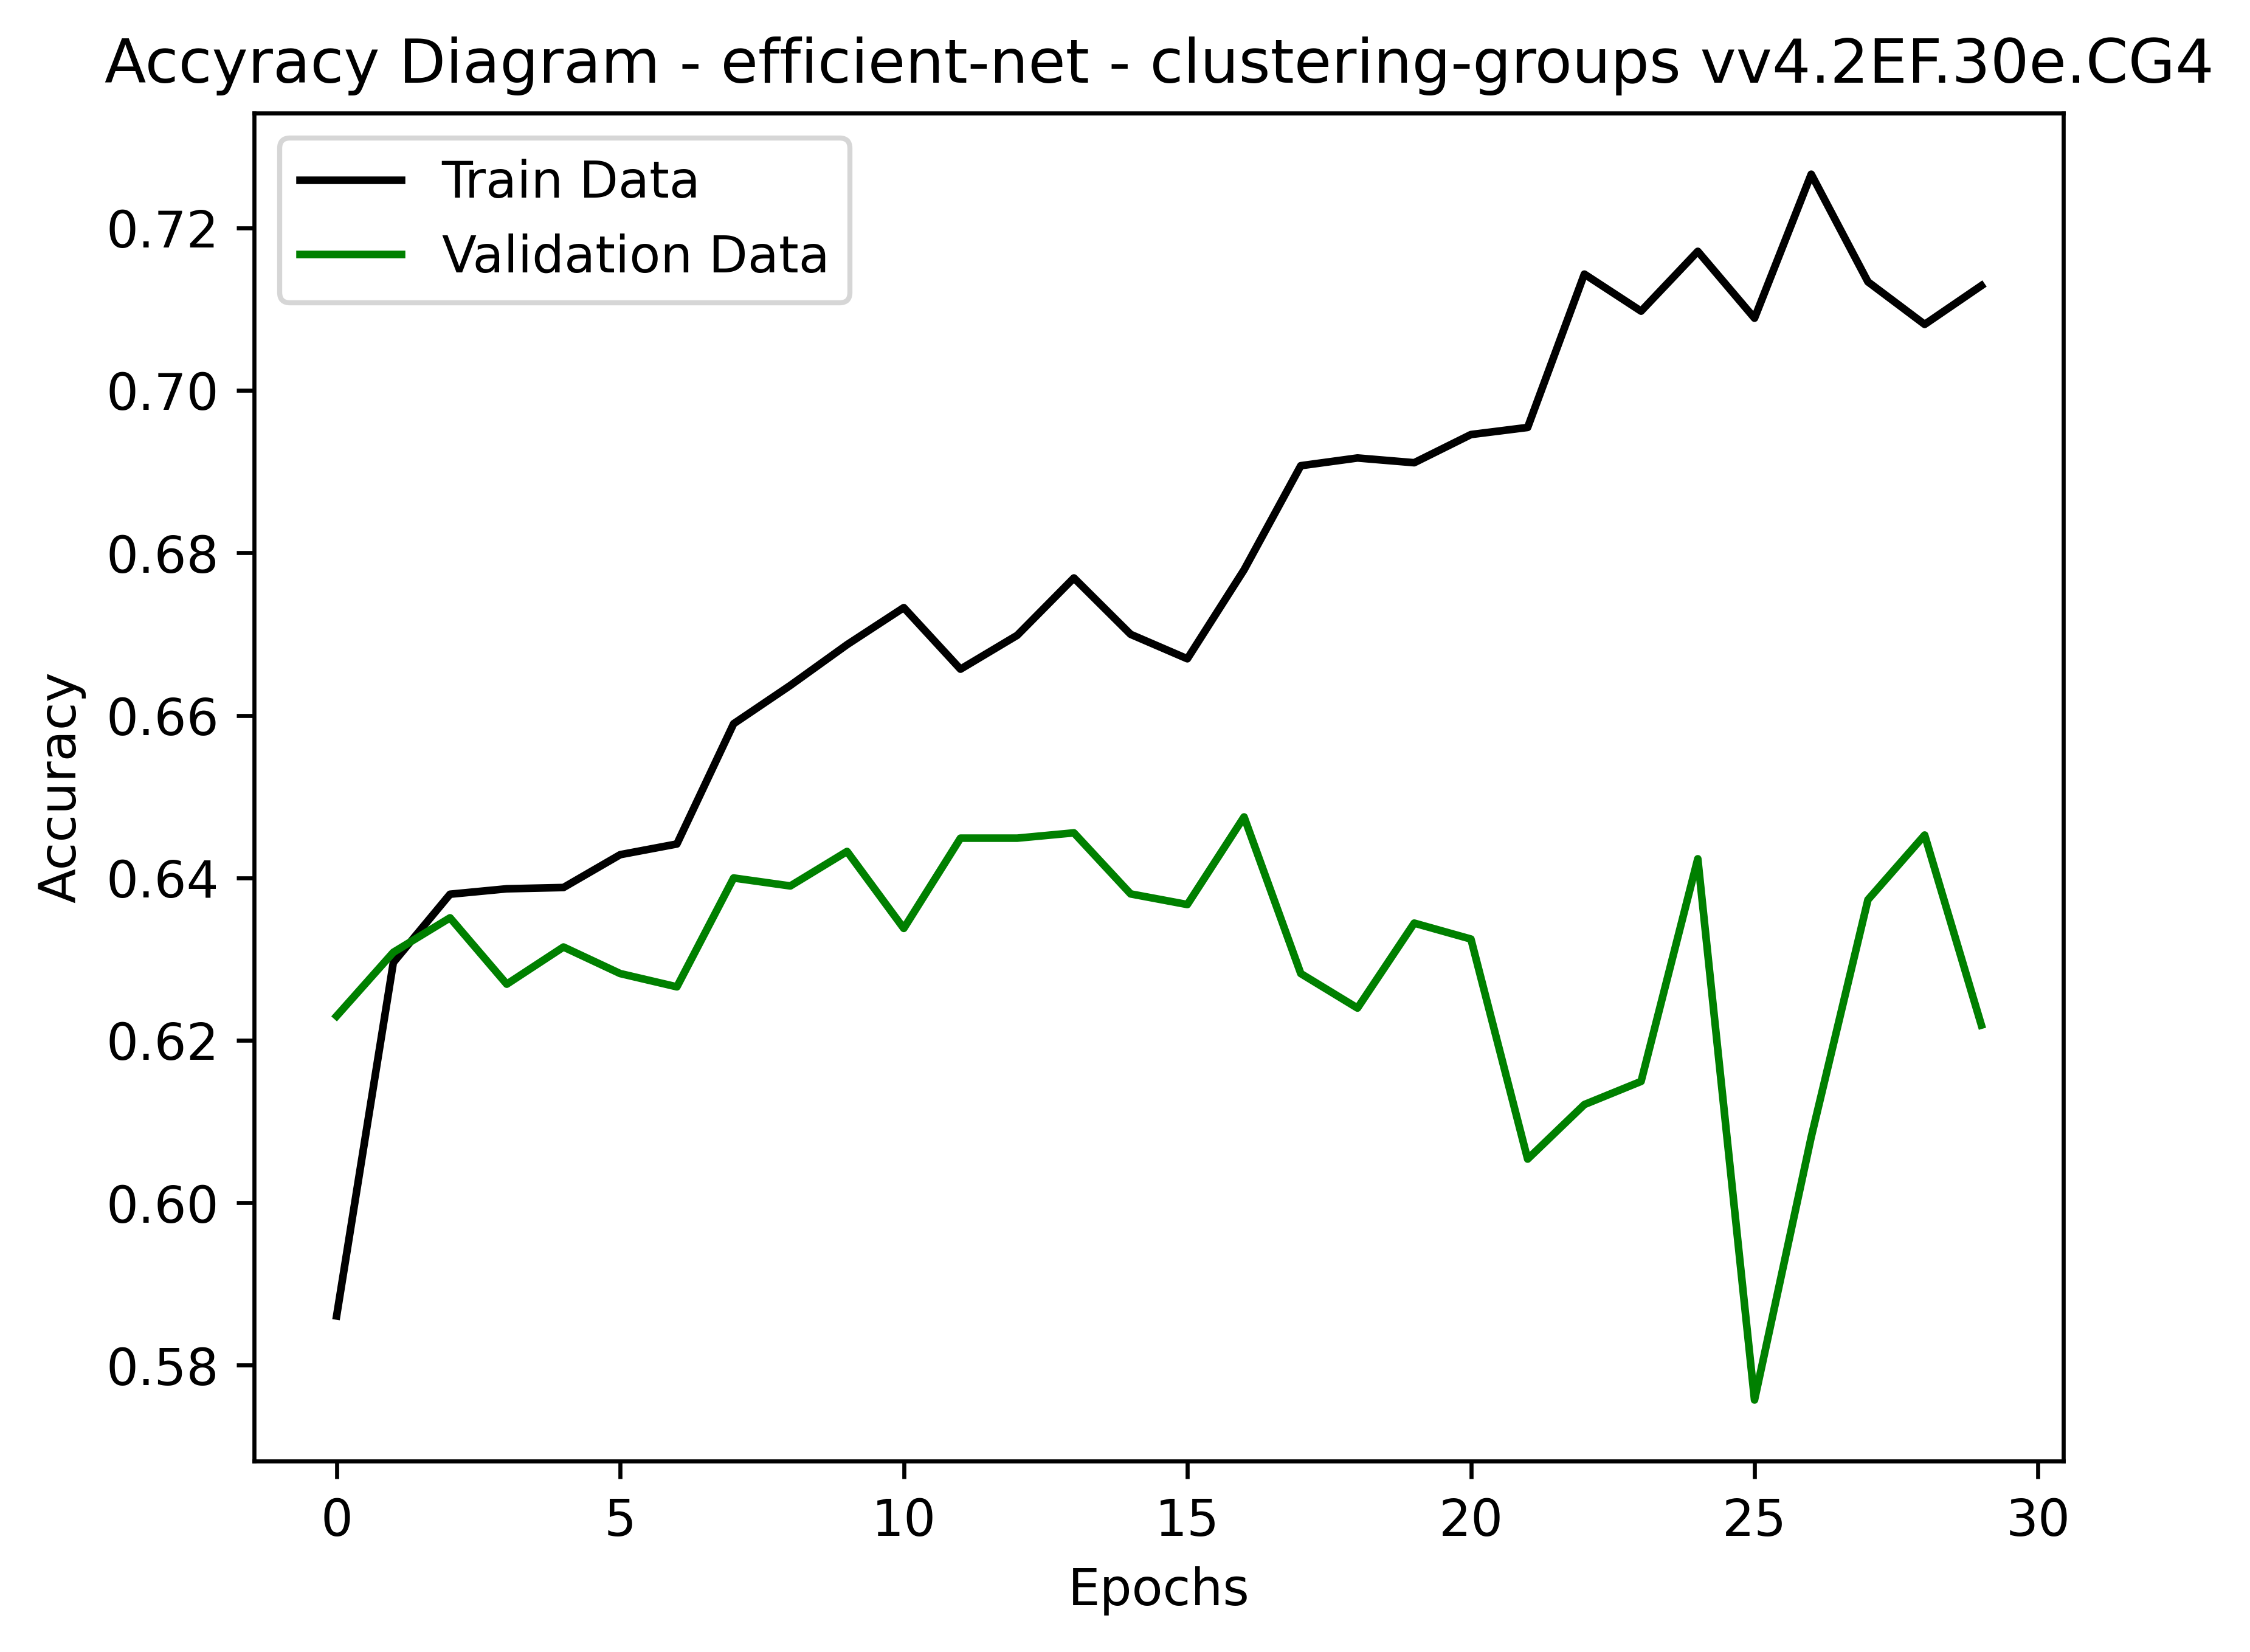

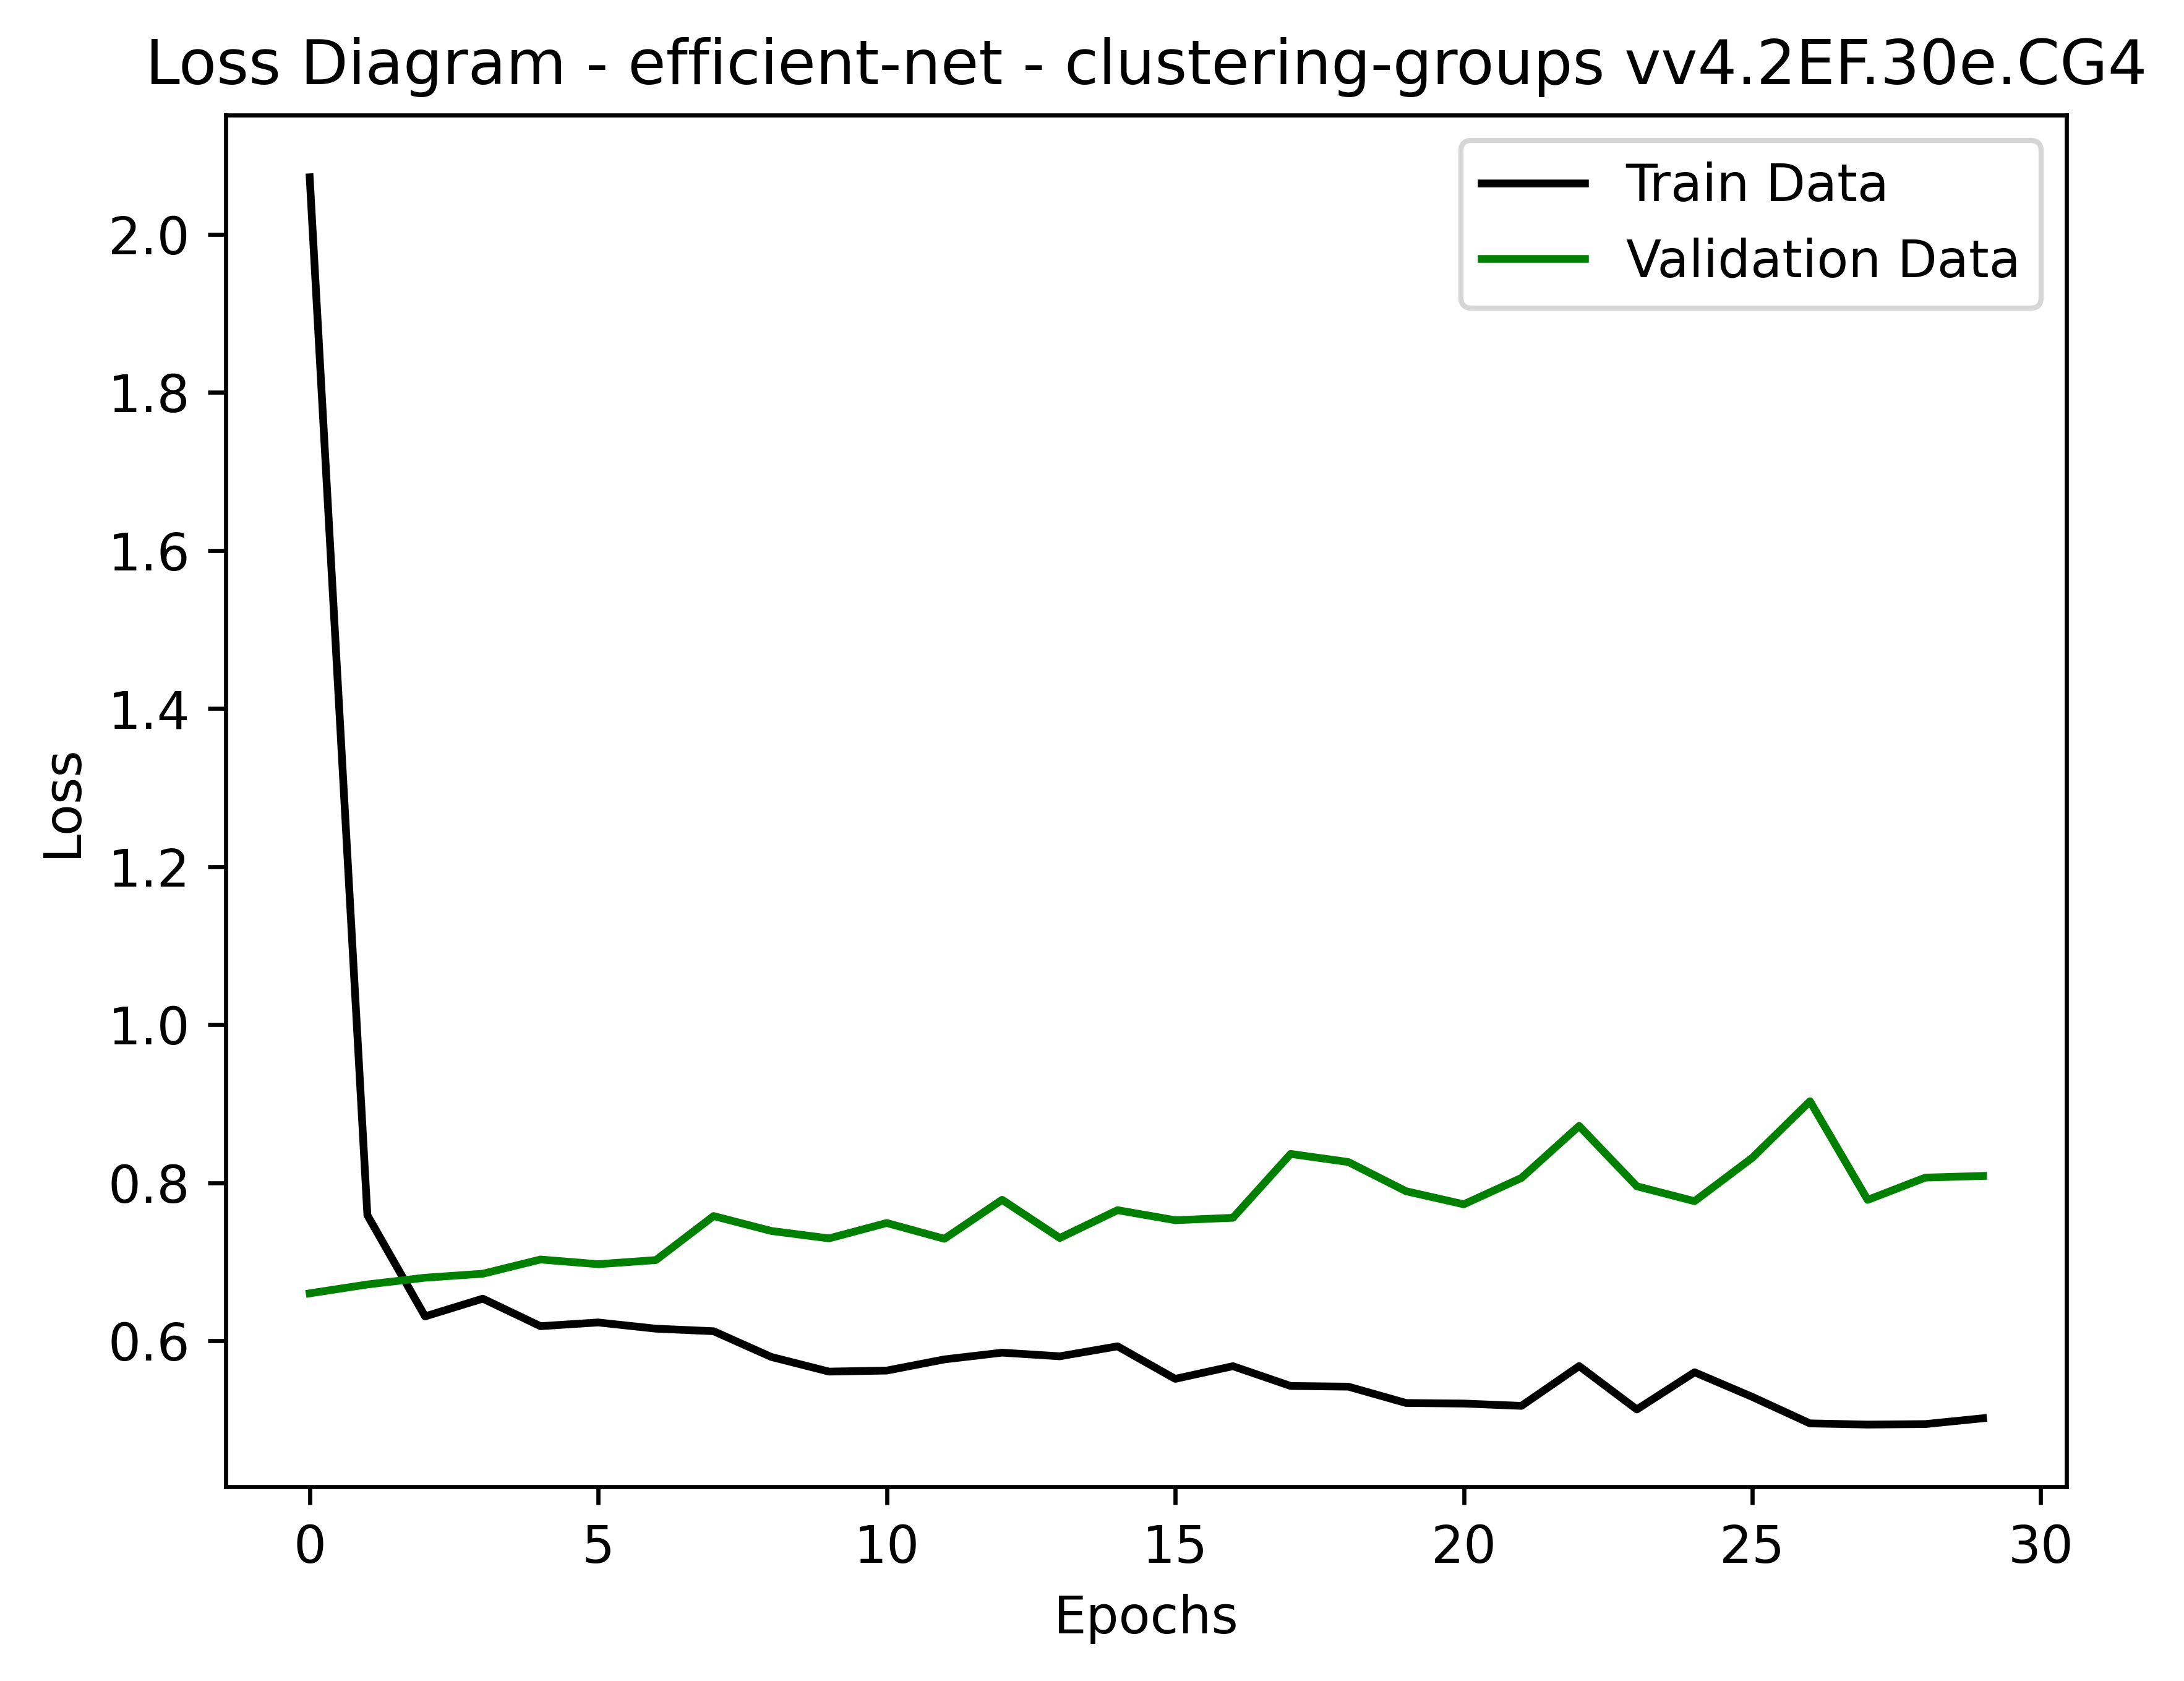

In [12]:
# PLOTAGEM DOS GRÁFICOS DE ACURÁCIA E TREINO POR ÉPOCA

def NetPlot():

    losses=[]
    val_losses=[]
    accuracies=[]
    val_accuracies=[]

    for item in results["historys"]:

        history=item.history
        loss=history['loss']
        val_loss=history['val_loss']
        accuracy=history['categorical_accuracy']
        val_accuracy=history['val_categorical_accuracy']

        losses.append(loss)
        val_losses.append(val_loss)
        accuracies.append(accuracy)
        val_accuracies.append(val_accuracy)

    losses2=np.zeros((1, EPOCHS))
    val_losses2=np.zeros((1, EPOCHS))
    accuracies2=np.zeros((1, EPOCHS))
    val_accuracies2=np.zeros((1, EPOCHS))

    for i in accuracies: accuracies2+=i
    for i in losses: losses2+=i

    for i in val_accuracies: val_accuracies2+=i    
    for i in val_losses: val_losses2+=i

    losses2=(losses2/N_SPLITS).flatten()
    accuracies2=(accuracies2/N_SPLITS).flatten()
    val_losses2=(val_losses2/N_SPLITS).flatten()
    val_accuracies2=(val_accuracies2/N_SPLITS).flatten()

    # print('\nAccuracies: '+ str(accuracies2) +'\nLosses: '+ str(losses2))

    plt.figure('Accuracy Diagram',dpi=600)
    plt.title(f'Accyracy Diagram - {MODEL_TYPE} - {DATASET_TYPE} v{VERSION}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(accuracies2,color='black')
    plt.plot(val_accuracies2,color='green')
    plt.legend(['Train Data','Validation Data'])

    plt.savefig(f'{RESULTS_PATH}/Accuracy-Diagram-{MODEL_TYPE}-v{VERSION}.jpg')

    plt.figure('Loss Diagram',dpi=600)
    plt.title(f'Loss Diagram - {MODEL_TYPE} - {DATASET_TYPE} v{VERSION}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(losses2,color='black')
    plt.plot(val_losses2,color='green')
    plt.legend(['Train Data','Validation Data'])

    plt.savefig(f'{RESULTS_PATH}/Loss-Diagram-{MODEL_TYPE}-v{VERSION}.jpg')
    
NetPlot()

## Imprimindo Informações

In [13]:
# IMPRIMINDO DAS INFORMAÇÕES

print(f"TREINAMENTO v{VERSION}\n")

print(f"Modelo: {MODEL_TYPE}\t  Dataset: {DATASET_TYPE}\t ehCompleto? {ehCompleto}")

print("\nParâmetros: ")
print(f"Épocas: {EPOCHS}\t Batch: {BATCH}\t Target Size: {TARGET}")

print("\n__________________________________________________________")
print("\nMÉTRICAS DO TREINO:")
print(f"\nAcurácias do Treino (accuracy): {train_metrics['accuracy']}")
print(f"Perdas do Treino (loss): {train_metrics['loss']}")
print(f"\nMatriz total do Treino:\n{total_train_matrix}")
#print(f"\nMédia das acurácias do Treino: {np.mean(train_metrics['accuracy'])}")
print(f"Acurácia total do Treino: {total_train_accuracy}")

print("\n__________________________________________________________")
print("\nMÉTRICAS DA VALIDAÇÃO:")
print(f"\nAcurácias do Validação (accuracy): {train_metrics['val_accuracy']}")
print(f"Perdas do Validação (loss): {train_metrics['val_loss']}")
print(f"\nMatriz total do Validação:\n{total_valid_matrix}")
#print(f"\nMédia das acurácias da Validação: {np.mean(train_metrics['val_accuracy'])}")
print(f"Acurácia total da Validação: {total_valid_accuracy}")

print("\n__________________________________________________________")
print("\nMÉTRICAS DO TESTE:")
print(f"\nAcurácias do Teste (accuracy): {results['test_accuracy']}")
print(f"Perdas do Teste (loss): {results['test_loss']}")
print(f"\nMatriz total do Teste:\n{total_test_matrix}")
#print(f"\nMédia das acurácias do Teste: {np.mean(history['test_accuracies'])}")
print(f"Acurácia total do Teste: {total_test_accuracy}")

print("\n__________________________________________________________")
print("MÉTRICAS PARA CADA FOLD:\n")
for i in range(len(results["reports"])):
    print(str(results["reports"][i]))
    print(f"\nTempo do Treinamento: {results['times'][i]}\t AUC: {results['AUC'][i]}")
    print(f"Acurácia: {results['test_accuracies'][i]}")
    print(f"Matriz de Confusao:\n{results['test_matrixs'][i]}")
    print("\n__________________________________________________________\n")

TREINAMENTO vv4.2EF.30e.CG4

Modelo: efficient-net	  Dataset: clustering-groups	 ehCompleto? True

Parâmetros: 
Épocas: 30	 Batch: 512	 Target Size: (100, 100)

__________________________________________________________

MÉTRICAS DO TREINO:

Acurácias do Treino (accuracy): [0.6320257961750031, 0.6544331034024556, 0.7033279339472452, 0.7288070420424143, 0.6622051556905111]
Perdas do Treino (loss): [0.6819931228955587, 0.6200147469838461, 0.5919587800900141, 0.5469292531410853, 0.6491797924041748]

Matriz total do Treino:
[[533.8 168. ]
 [157.  984.6]]
Acurácia total do Treino: 0.8237737803177693

__________________________________________________________

MÉTRICAS DA VALIDAÇÃO:

Acurácias do Validação (accuracy): [0.6009024053812027, 0.6088235318660736, 0.6600217839082082, 0.6538671016693115, 0.6260348578294118]
Perdas do Validação (loss): [0.6692630926767985, 0.7424062212308248, 0.794049064318339, 0.8559438288211823, 0.7525141100088756]

Matriz total do Validação:
[[ 84.6 148.8]
 [ 80.

## Salvando Informações

In [14]:
# SALVAMENTO DAS INFORMAÇÕES

print('\nSalvando informações da rede......................................!')

path = RESULTS_PATH + f'/results-v{VERSION}.txt'
    
data = open(path,'w')
data.write(f"TREINAMENTO v{VERSION}\n")

data.write(f"\nModelo: {MODEL_TYPE}\t  Dataset: {DATASET_TYPE}\t ehCompleto? {ehCompleto}")

data.write("\n\nParâmetros: ")
data.write(f"\nÉpocas: {EPOCHS}\t Batch: {BATCH}\t Target Size: {TARGET}")

data.write("\n\n__________________________________________________________")
data.write("\n\nMÉTRICAS DO TREINO:")
data.write(f"\n\nAcurácias do Treino (accuracy): {train_metrics['accuracy']}")
data.write(f"\nPerdas do Treino (loss): {train_metrics['loss']}")
data.write(f"\n\nMatriz total do Treino:\n{total_train_matrix}")
#data.write(f"\n\nMédia das acurácias do Treino: {np.mean(train_metrics['accuracy'])}")
data.write(f"\nAcurácia total do Treino: {total_train_accuracy}")

data.write("\n\n__________________________________________________________")
data.write("\n\nMÉTRICAS DA VALIDAÇÃO:")
data.write(f"\n\nAcurácias do Validação (accuracy): {train_metrics['val_accuracy']}")
data.write(f"\nPerdas do Validação (loss): {train_metrics['val_loss']}")
data.write(f"\n\nMatriz total do Validação:\n{total_valid_matrix}")
#print(f"\n\nMédia das acurácias da Validação: {np.mean(train_metrics['val_accuracy'])}")
data.write(f"\nAcurácia total da Validação: {total_valid_accuracy}")

data.write("\n\n__________________________________________________________")
data.write("\n\nMÉTRICAS DO TESTE:")
data.write(f"\n\nAcurácias do Teste (accuracy): {results['test_accuracy']}")
data.write(f"\nPerdas do Teste (loss): {results['test_loss']}")
data.write(f"\n\nMatriz total do Teste:\n{total_test_matrix}")
#data.write(f"\n\nMédia das acurácias do Teste: {np.mean(history['test_accuracies'])}")
data.write(f"\nAcurácia total do Teste: {total_test_accuracy}")

data.write("\n\n__________________________________________________________")
data.write("\nMÉTRICAS PARA CADA FOLD:\n\n")
for i in range(len(results["reports"])):
    data.write(str(results["reports"][i]))
    data.write(f"\n\nTempo do Treinamento: {results['times'][i]}\t AUC: {results['AUC'][i]}")
    data.write(f"\nAcurácia: {results['test_accuracies'][i]}")
    data.write(f"\nMatriz de Confusao:\n{results['test_matrixs'][i]}")
    data.write("\n\n__________________________________________________________\n")

data.close()


Salvando informações da rede......................................!
